<a href="https://colab.research.google.com/github/OswaldCc/Driver-Drowsiness-Detection-In-Cars/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition
## Specifying the Question
Deploy a neural network model to a webcam application that will give an alert to the driver if they have their eyes closed for more than 3 seconds.

## Defining the metrics for success
This study will be considered successful if:
- It achieves an AUC score of 0.97.

## Understanding the context
For drowsiness detection, our goal is to correctly detect whether one has their eyes open or closed. If the eyes remain closed for more than three seconds the driver should receive an alert to wake them up. According to the following article by WebMD, if you doze off for 3 seconds while at a speed of 27 meters per second you can travel 92 meters in the wrong direction and another article by the NSW Health Organization states that during a four-second microsleep, a car traveling at 100 km/h will travel 111 meters while completely out of the driver’s control.

## Data Understanding
The data is from [Kaggle](<https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset>) it was created with the help of a larger-scale dataset of human eyes from Media Research Lab.

The dataset contains images of the eye state whether open or closed. Of the 4000 images, 2000 are open eyes, and 2000 are closed eyes some with glasses some without. The images have a bit depth of 8. The dataset contains images with high and low resolution since they were captured by different devices under different lighting conditions.

### Loading Libraries

In [93]:
#Importing libraries


import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, accuracy_score, auc, plot_roc_curve, roc_auc_score,recall_score, precision_score, f1_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from PIL import Image as im
import seaborn as sns
import tensorflow as tf
tf.random.set_seed(2)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading Data

In [94]:
#Connecting colab to gooogle drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
#Loading images from the folders and labelling them
def load_images_from_folder(folder,eyes):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        img=cv2.resize(img,(80,80))
        images.append([img,eyes])
    return images

In [96]:

folder="/content/drive/Shareddrives/Elite Drive/train/Closed_Eyes"
open_eyes=load_images_from_folder(folder,0)

folder="/content/drive/Shareddrives/Elite Drive/train/Open_Eyes"
closed_eyes=load_images_from_folder(folder,1)


In [97]:
#Number of Images
#
print(len(open_eyes))
print(len(closed_eyes))

2000
2000


### Previewing Data

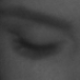

In [98]:
#Displaying image to confirm that they have been loaded 
from PIL import Image as im
data=im.fromarray(open_eyes[0][0])
data

In [99]:
#Combining the open and closed eye data 
eyes=open_eyes+closed_eyes

### Reshaping, Normalization and Splitting

In [100]:
#Setting up images with X being images and y being labels
X=[]
y=[]

for features, label in eyes:
    X.append(features)
    y.append(label)



In [101]:
#Converting image to array for modelling and scaling by dividing by 255
X=np.array(X).reshape(-1,80,80,3)
y=np.array(y)
X=X/255.0

In [102]:
# Splitting the data 

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=23 )


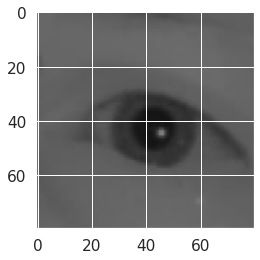

In [103]:
#confirming that split ran okay

plt.figure()
plt.imshow(X_train[10])
plt.show()

In [104]:
#class names for images shown below 

class_names=['open','close']

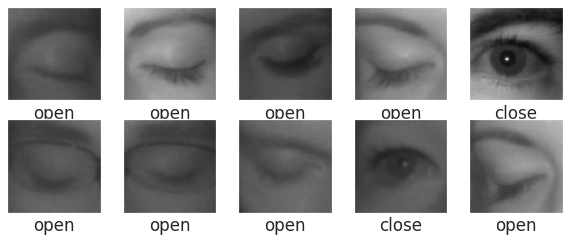

In [105]:
#producing images of training set with corresponding label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

In [106]:
#Reshping imags to 80*80*3 just incase 
X_train=X_train.reshape(X_train.shape[0], 80,80,3)
X_test=X_test.reshape(X_test.shape[0], 80,80,3)

# Modelling

In [107]:
#creating a function that returns a Keras model
def deep_learning_model(dense_neurons1=128,dense_neurons2=128,dense_neurons3=128,layout='',filters=32,dropout=None,pooling=None):
  model=Sequential()
  if layout== '5x5':
    model.add(Conv2D(filters=filters, kernel_size=(5,5),activation='relu',input_shape=(80,80,3)))

  if layout=='3x3'or layout== '2*3x3':
    model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))

#adding pooling for convlutional layers
  if pooling!=None:
    model.add(MaxPooling2D(pool_size=(2,2)))

  if layout=='2*3x3':
    #second layer
      model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
#adding pooling on 2*3x3
  if pooling !=None and layout =='2*3x3':
    model.add(MaxPooling2D(pool_size=(2,2)))

#flatten model for dense layers
  model.add(Flatten())
  model.add(Dense(dense_neurons1,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons2,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons3,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))

#adding output layer

  model.add(Dense(1,activation='sigmoid'))

  #compiling using binary cross entropy and using AUC as metric 
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.AUC(curve='PR')])

  return model







    


In [108]:
#Defining an earlystop callback
early_stop=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=.05)

In [109]:
#first grid search parameters
params_deep={
    "layout":['3x3','5x5','2*3x3'],
    "dense_neurons1":[64,128],
    'filters':[8,18,32],
    "dropout":[0.1,0.5,],
    "pooling":[None,1],
    "epochs":[10]

}

In [110]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep,cv=3,scoring='average_precision')
gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

In [112]:
print(f'Best Accuracy for {gs_deep.best_score_} using {gs_deep.best_params_}')


From this grid search we find the best layout to be 2*3x3 with 32 filters. This means we will have two convolution layers with a kernel size of (3,3) representing the height and width of the filter. We will perform other iterations on the same layout but with three layers of dense neurons and different hyperparameters.

In [113]:
#Second grid search parameters
params_deep_two={
    "layout":['2*3x3'],
    "dense_neurons1":[128,256],
    "dense_neurons2":[256,512],
    "dense_neurons3":[256,512],
    'filters':[32],
    "dropout":[0,0.1,0.3,0.5,],
    "pooling":[None,1],
    "epochs":[20]

}

In [114]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep_two,cv=3,scoring='average_precision')
gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

In [116]:
print(f'Best Accuracy for {gs_deep.best_score_} using {gs_deep.best_params_}')

## Grid search Analysis

Given that we have an accuracy of 0.998397543919476, which is better than the neural network architecture with one dense layer at 0.999472216392248  , we can take these as the  parameters to build our final model.

Final model for Export

AUC score of model produced by grid search: 0.9998397543919476

Parameters of best model produced by grid search:

- dense_neurons1: 256,
- dense_neurons2: 512,
- dense_neurons3: 512, 
- dropout: 0.3, 
- epochs: 20, 
- filters: 32, 
- layout: '2*3x3', 
- pooling: 1




In [117]:
#instantiate the model
model=Sequential()

#adding first convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
#maxpooling after convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

#adding another convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
#maxpooling after convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#adding first dense layer with 256 nodes
model.add(Dense(256, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#adding second dense layer with 512 nodes
model.add(Dense(512, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#adding third dense layer with 512 nodes
model.add(Dense(512, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#Output layer
model.add(Dense(1, activation='sigmoid'))
#compiling 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])

#fitting on train data
history=model.fit(X_train,y_train,batch_size=200, epochs=20, validation_data=(X_test,y_test))

Epoch 1/20
15/15 [==============================] - 2s 64ms/step - loss: 0.6614 - auc_3: 0.6350 - val_loss: 0.4158 - val_auc_3: 0.9441
Epoch 2/20
15/15 [==============================] - 1s 39ms/step - loss: 0.4157 - auc_3: 0.9011 - val_loss: 0.2357 - val_auc_3: 0.9856
Epoch 3/20
15/15 [==============================] - 1s 38ms/step - loss: 0.1811 - auc_3: 0.9826 - val_loss: 0.0833 - val_auc_3: 0.9966
Epoch 4/20
15/15 [==============================] - 1s 38ms/step - loss: 0.0922 - auc_3: 0.9943 - val_loss: 0.0354 - val_auc_3: 0.9992
Epoch 5/20
15/15 [==============================] - 1s 38ms/step - loss: 0.0413 - auc_3: 0.9981 - val_loss: 0.0188 - val_auc_3: 0.9999
Epoch 6/20
15/15 [==============================] - 1s 43ms/step - loss: 0.0236 - auc_3: 0.9989 - val_loss: 0.0174 - val_auc_3: 0.9999
Epoch 7/20
15/15 [==============================] - 1s 37ms/step - loss: 0.0228 - auc_3: 0.9997 - val_loss: 0.0052 - val_auc_3: 1.0000
Epoch 8/20
15/15 [==============================] - 1s 

In [118]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (200, 78, 78, 32)         896       
                                                                 
 max_pooling2d_4 (MaxPooling  (200, 39, 39, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (200, 37, 37, 32)         9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (200, 18, 18, 32)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (200, 10368)              0         
                                                                 
 dense_12 (Dense)            (200, 256)               

In [119]:
# function to evaluate model
def evaluate(model):
  results_train = model.evaluate(X_train, y_train)
  print(f'Training Loss: {results_train[0]} \nTraining auc score: {results_train[1]}')

  print('----------')

  results_test =model.evaluate(X_test, y_test)
  print(f'Test Loss: {results_test[0]} \nTest auc score: {results_test[1]}')




evaluate(model)

94/94 [==============================] - 1s 5ms/step - loss: 2.9328e-04 - auc_3: 1.0000
Training Loss: 0.00029328104574233294 
Training auc score: 1.0
----------
32/32 [==============================] - 0s 5ms/step - loss: 0.0071 - auc_3: 1.0000
Test Loss: 0.007078550755977631 
Test auc score: 0.9999833106994629


In [120]:
# Plot the loss and auc curves for training and validation 
def evaluation_visual(model,auc,val_auc):
  fig, ax = plt.subplots(2,1,figsize=(10,8))
  ax[0].plot(model.history['loss'], color='b', label="Training loss")
  ax[0].plot(model.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)
  plt.xlabel('Epoch')
  plt.ylabel('Metric')

 
  ax[1].plot(model.history[auc], color='b', label="Training auc score")
  ax[1].plot(model.history[val_auc], color='r',label="Validation auc score")
  legend = ax[1].legend(loc='best', shadow=True)
  plt.xlabel('Epoch')
  plt.ylabel('Metric')


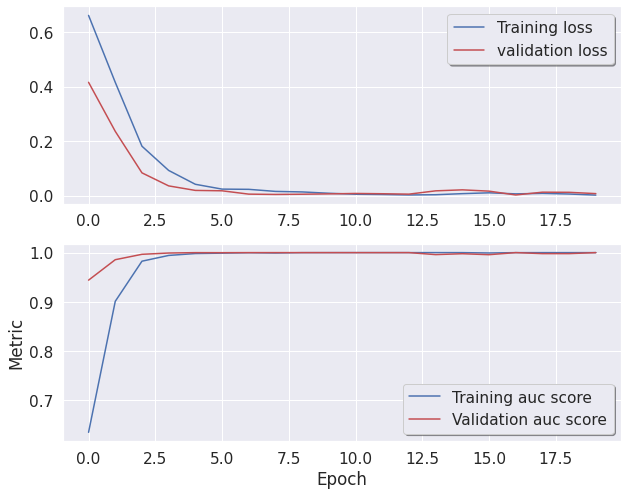

In [122]:

evaluation_visual(history,'auc_3','val_auc_3')

In [123]:
#making predictions
preds=model.predict(X_test)
preds.round(1)
preds

array([[5.30118949e-10],
       [1.00000000e+00],
       [3.78961182e-08],
       [1.00000000e+00],
       [9.99989152e-01],
       [2.34702857e-05],
       [9.99987245e-01],
       [1.06010589e-07],
       [5.12037190e-10],
       [7.03804091e-08],
       [9.99993324e-01],
       [9.99996901e-01],
       [1.80873400e-10],
       [9.93748903e-11],
       [3.02280614e-06],
       [1.00000000e+00],
       [1.83075870e-04],
       [9.99980092e-01],
       [4.22475194e-10],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.68892038e-05],
       [2.15268052e-08],
       [1.00000000e+00],
       [5.06074384e-11],
       [1.66124994e-06],
       [2.20383684e-10],
       [1.00000000e+00],
       [9.99777377e-01],
       [7.25740611e-05],
       [1.00000000e+00],
       [1.75752376e-07],
       [1.00000000e+00],
       [9.99873638e-01],
       [1.02222812e-05],
       [2.29823468e-06],
       [1.21815301e-05],
       [1.00000000e+00],
       [1.00000000e+00],


In [124]:
#coming up with a confusion matrix
confusion_matrix=tf.math.confusion_matrix(labels=y_test,predictions=preds.round()).numpy()

confusion_matrix

array([[508,   2],
       [  0, 490]], dtype=int32)

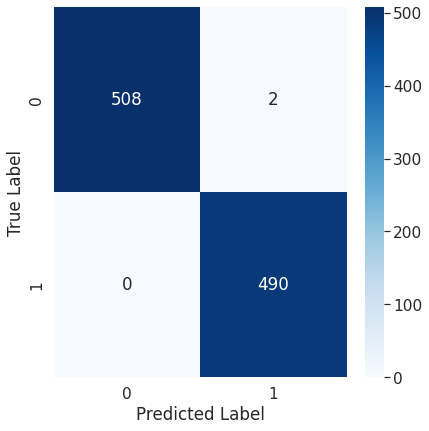

In [125]:
#visualising the confusion matrix

import seaborn as sns 
figure =plt.figure(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix,annot=True,cmap=plt.cm.Blues,fmt='g')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [126]:
tn, fp, fn, tp =confusion_matrix.ravel()

In [127]:
#Calculating recall
recall=tp/(tp+fp)
print(f'recall: {recall}')
#Calculating precision
precision=tp/(tp+fn)
print(f'precision: {precision}')
#Calculating f1-score
f1_score=(precision*recall)/(precision+recall)
print(f'f1_score: {f1_score}')
#Calculating accuracy
accuracy=(tn+tp)/(tn+fp+fn+tp)
print(f'accuracy: {accuracy}')

recall: 0.9959349593495935
precision: 1.0
f1_score: 0.4989816700610998
accuracy: 0.998


In [128]:
#Saving the best model
model.save('./webcam_script/final_model.h5')

# Challenging the model
For this section, a transfer learning model will be used to test whether it performs better than the final model chosen from the grid search.Transfer learning for image classification is about leveraging feature representations from a pre-trained model, so you don't have to train a new model from scratch. The pre-trained models are usually trained on massive datasets that are a standard benchmark in the computer vision frontier.

More spefically in this project will use VGG19, which is an advanced network with pretrained layers and a better understanding of what defines an image in terms of shape, color, and structure. VGG19 is very deep and has been trained on millions of diverse images with complex classification tasks.

VGG19 consists of 19 layers:

16 convolution layers
5 MaxPool layers
1 SoftMax layer
3 fully connected layers

In [129]:
vgg19_model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(80, 80, 3))

The VGG19 model wasn't trained any further, only froze its layers and appended a shallow 2 layer network on top of it to perform my classification task of identifying images of closed and open eyes.

In [130]:

#Add the pretrained model as the first layer and adding dense layers
vgg_model =Sequential()
vgg_model.add(vgg19_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(132, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))

Freezing layers
This means that all of the weights associated with that layer(s) will remain unchanged through the optimization process. Freezing the base is important as you wish to preserve the features encoded in this CNN base. Without this, the volatile gradients will quickly erase the useful features of the pretrained model.

In [131]:
# Checking whether a layer is trainable
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)
    
# Checking how many trainable weights are in the model
print(len(vgg_model.trainable_weights))

vgg19 True
flatten_5 True
dense_16 True
dense_17 True
36


In [132]:
# Checking whether a layer is trainable
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)
    
# Checking how many trainable weights are in the model
print(len(vgg_model.trainable_weights))

vgg19 True
flatten_5 True
dense_16 True
dense_17 True
36


In [140]:
#compiling 
vgg_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])

#fitting on train data
history2 = vgg_model.fit(X_train,y_train,batch_size=200, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
15/15 [==============================] - 9s 511ms/step - loss: 0.0659 - auc_6: 0.9925 - val_loss: 0.0600 - val_auc_6: 0.9972
Epoch 2/10
15/15 [==============================] - 7s 486ms/step - loss: 0.0144 - auc_6: 0.9998 - val_loss: 0.0210 - val_auc_6: 0.9979
Epoch 3/10
15/15 [==============================] - 7s 489ms/step - loss: 0.0070 - auc_6: 0.9998 - val_loss: 0.0072 - val_auc_6: 1.0000
Epoch 4/10
15/15 [==============================] - 7s 490ms/step - loss: 0.0147 - auc_6: 0.9989 - val_loss: 0.0387 - val_auc_6: 0.9969
Epoch 5/10
15/15 [==============================] - 7s 495ms/step - loss: 0.0118 - auc_6: 0.9997 - val_loss: 0.0094 - val_auc_6: 0.9999
Epoch 6/10
15/15 [==============================] - 7s 497ms/step - loss: 0.0065 - auc_6: 0.9998 - val_loss: 0.0158 - val_auc_6: 0.9993
Epoch 7/10
15/15 [==============================] - 7s 498ms/step - loss: 3.0596e-04 - auc_6: 1.0000 - val_loss: 6.4807e-04 - val_auc_6: 1.0000
Epoch 8/10
15/15 [======================

In [141]:
vgg_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 132)               270468    
                                                                 
 dense_17 (Dense)            (None, 1)                 133       
                                                                 
Total params: 20,294,985
Trainable params: 20,294,985
Non-trainable params: 0
_________________________________________________________________


In [142]:
evaluate(vgg_model)

94/94 [==============================] - 3s 33ms/step - loss: 3.5179e-07 - auc_6: 1.0000
Training Loss: 3.5179076007807453e-07 
Training auc score: 1.0
----------
32/32 [==============================] - 1s 34ms/step - loss: 7.1433e-06 - auc_6: 1.0000
Test Loss: 7.14333646101295e-06 
Test auc score: 1.0


The transfer learning model seems to get a slightly better score. It has a score of 1.

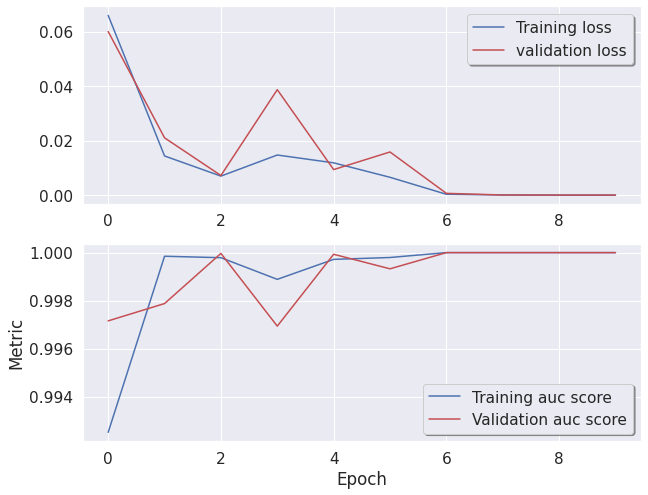

In [143]:
evaluation_visual(history2,'auc_6','val_auc_6')

# Areas for Further Research
- Low Light conditions, accounting for other passengers
- Additional test data for closed eyes
- Image augmentation like rotated or flipped images
- Deployment of app to remote server